In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Concatenate, Dropout, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model

2025-06-25 14:23:33.391523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750875813.404098  203648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750875813.407791  203648 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750875813.418008  203648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750875813.418018  203648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750875813.418020  203648 computation_placer.cc:177] computation placer alr

In [10]:
# Constants
NUM_CLASSES = 8
NUM_LANDMARKS = 99
NUM_FEATURES = 6

In [11]:
# Load in the data
# data = np.load('../data/segmentedPose.npy')
data = np.load('../data/segmentedPose_augmented.npy')
X = data[:,0:-1]
X_lmk = X[:,0:NUM_LANDMARKS]
X_features = X[:,NUM_LANDMARKS:-1]
y = data[:,-1].astype(int)

# Convert y to categorical data
y = to_categorical(y, num_classes=NUM_CLASSES)

In [21]:
# Get training and test splits
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=71)

# Split X into pose vs other features
X_train_lmk = X_train[:,0:NUM_LANDMARKS]
X_train_features = X_train[:,NUM_LANDMARKS:]


X_val_lmk = X_val[:,0:NUM_LANDMARKS]
X_val_features = X_val[:,NUM_LANDMARKS:]

In [32]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(99,)),
#     tf.keras.layers.Reshape((33, 3)),
#     tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(99,)),
#     tf.keras.layers.Reshape((33, 3)),

#     tf.keras.layers.Conv1D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),

#     tf.keras.layers.Conv1D(128, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),

#     tf.keras.layers.Conv1D(256, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),

#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(64),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

########### Dual Input Model ###########
# ---- Input 1: Flattened pose landmarks (shape = 99,) ----
pose_input = Input(shape=(99,), name="pose_input")
x1 = Reshape((33, 3))(pose_input)  # Reshape to (33, 3)
x1 = Conv1D(64, kernel_size=9, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(128, kernel_size=9, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Flatten()(x1)

# ---- Input 2: Engineered features (e.g., angles, distances) ----
eng_input = Input(shape=(NUM_FEATURES,), name="eng_input")
x2 = Dense(128)(eng_input)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
x2 = Dropout(0.2)(x2)

# ---- Combine both branches ----
combined = Concatenate()([x1, x2])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)
combined = Dense(64, activation='relu')(combined)
output = Dense(NUM_CLASSES, activation='softmax')(combined)

In [33]:
# Initialize optimizer and model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.9
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,             # Wait 10 epochs with no improvement
    restore_best_weights=True,  # Restore the best weights (not the last ones)
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Reduce learning rate by half
    patience=5,       # Wait 5 epochs with no improvement
    min_lr=1e-6,      # Don't go below this learning rate
    verbose=1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [34]:
# # Compile the model
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')
#     ]
# )

# ---- Build and compile ----
model = Model(inputs=[pose_input, eng_input], outputs=output)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [35]:
# Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
history = model.fit(
    x={"pose_input": X_train_lmk, "eng_input": X_train_features},
    y=y_train,
    validation_data=(
        {"pose_input": X_val_lmk, "eng_input": X_val_features},
        y_val
    ),
    batch_size=64,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


2025-06-25 14:28:59.445488: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2075', 20 bytes spill stores, 20 bytes spill loads

2025-06-25 14:28:59.498394: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2075', 684 bytes spill stores, 552 bytes spill loads



133/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4335 - loss: 1.6006 - precision: 0.5690 - recall: 0.2698

2025-06-25 14:29:02.399217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2075', 36 bytes spill stores, 36 bytes spill loads

2025-06-25 14:29:02.639335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2075', 20 bytes spill stores, 20 bytes spill loads

2025-06-25 14:29:02.722269: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2075', 492 bytes spill stores, 492 bytes spill loads



152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4461 - loss: 1.5593 - precision: 0.5815 - recall: 0.2848 - val_accuracy: 0.2198 - val_loss: 1.9037 - val_precision: 0.2857 - val_recall: 0.0058 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6581 - loss: 0.9372 - precision: 0.7585 - recall: 0.5528 - val_accuracy: 0.2745 - val_loss: 1.9693 - val_precision: 0.3436 - val_recall: 0.2292 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7153 - loss: 0.7727 - precision: 0.7894 - recall: 0.6298 - val_accuracy: 0.6169 - val_loss: 0.9986 - val_precision: 0.7663 - val_recall: 0.4560 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7441 - loss: 0.7000 - precision: 0.8103 - recall: 0.6787 - val_accuracy: 0.7070 - val_loss: 0.7817 - val_precision: 0.8011 - val_recall: 0.6099 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881

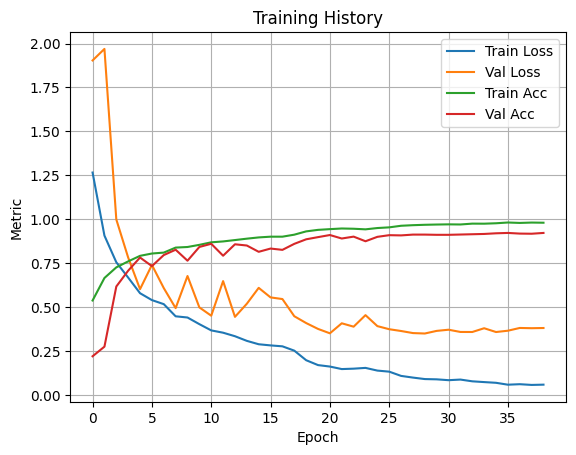

In [36]:
# Plot a training history graph
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
# plt.plot(history.history['precision'], label='Precision')
# plt.plot(history.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()